###  MicroGrad demo

In [1]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from numpy import ndarray
from sklearn.datasets import make_moons

from karpathy_nn.micrograd.engine import Value
from karpathy_nn.micrograd.nn import MLP
from karpathy_nn.micrograd.utils import apply_random_seed


In [2]:
apply_random_seed(1337)


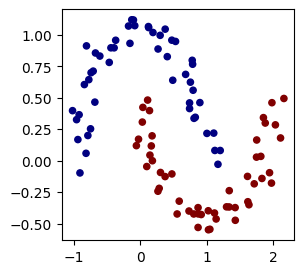

In [3]:
# Make a dataset
X, y = make_moons(n_samples=100, noise=0.1)

y = 2 * y - 1  # Transform y to -1 or 1
# Visualize dataset in 2D
plt.figure(figsize=(3, 3))
_ = plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="jet")


In [4]:
# initialize a model
model = MLP(
    num_input_neurons=2, num_output_neurons_per_layer=[16, 16, 1], final_act="None"
)  # 2-layer neural network
print(model)
print("Number of parameters:", len(model.parameters()))


MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [NoneNeuron(16)]]
Number of parameters: 337


In [5]:
# "Dataloader"
def get_minibatch(
    X: ndarray, y: ndarray, batch_size: Optional[int] = None
) -> tuple[ndarray, ndarray]:
    """Returns a mini-batch of size ``batch_size`` from ``X`` and ``y``.

    Args:
        X: NumPy array containing the inputs of the dataset.
        y: NumPy array containing the targets of the dataset.
        batch_size: The size of the mini-batch.
            If ``None``, the entire dataset is returned.

    Returns:
        A tuple of the mini-batch inputs and the mini-batch outputs.

    """
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]

    Xb = [list(map(Value, xrow)) for xrow in Xb]

    return Xb, yb


# Loss function
def hinge_loss(Xb: list[list[Value]], yb: ndarray) -> tuple[Value, float]:
    """Calculates the hinge loss on the provided mini-batch. Also returns the accuracy."""
    # Forward the model to get scores
    scores = list(map(model, Xb))

    # SVM hinge loss
    losses = [(1 - yi * scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    lambda_ = 1e-4
    reg_loss = 0  # lambda_ * sum((p * p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # Calculate accuracy
    accuracy_list = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    accuracy = sum(accuracy_list) / len(accuracy_list)
    return total_loss, accuracy


total_loss, acc = hinge_loss(*get_minibatch(X, y))
print(total_loss, acc)


Value(data=0.8862514464368222, grad=0) 0.5


In [6]:
def train(model: MLP, X: ndarray, y: ndarray, num_epochs: int = 100) -> None:
    """Implements a basic training loop."""
    # Optimization
    for epoch in range(num_epochs):
        # Forward
        total_loss, accuracy = hinge_loss(*get_minibatch(X, y))

        # Backward
        model.zero_grad()
        total_loss.backward()

        # Update (SGD)
        learning_rate = 1 - 0.9 * epoch / 100
        for p in model.parameters():
            p.data -= learning_rate * p.grad

        print(f"Epoch {epoch}: loss {total_loss.data}, accuracy {accuracy * 100}%")


train(model, X, y)


Epoch 0: loss 0.8862514464368222, accuracy 50.0%
Epoch 1: loss 1.7136790633950052, accuracy 81.0%
Epoch 2: loss 0.7333961267286992, accuracy 77.0%
Epoch 3: loss 0.7615247055858602, accuracy 82.0%
Epoch 4: loss 0.359780833345342, accuracy 84.0%
Epoch 5: loss 0.3039360355411296, accuracy 86.0%
Epoch 6: loss 0.2716587340549048, accuracy 89.0%
Epoch 7: loss 0.258965768030132, accuracy 91.0%
Epoch 8: loss 0.24684455035335173, accuracy 91.0%
Epoch 9: loss 0.26038987927745966, accuracy 91.0%
Epoch 10: loss 0.23569710047306522, accuracy 91.0%
Epoch 11: loss 0.24037689302294765, accuracy 92.0%
Epoch 12: loss 0.20603128479123115, accuracy 91.0%
Epoch 13: loss 0.220611577960292, accuracy 93.0%
Epoch 14: loss 0.19010711228374733, accuracy 92.0%
Epoch 15: loss 0.21687609382796408, accuracy 93.0%
Epoch 16: loss 0.1864244534217525, accuracy 92.0%
Epoch 17: loss 0.20644781960886666, accuracy 92.0%
Epoch 18: loss 0.15299793102189646, accuracy 94.0%
Epoch 19: loss 0.18164592701596202, accuracy 93.0%
Epo

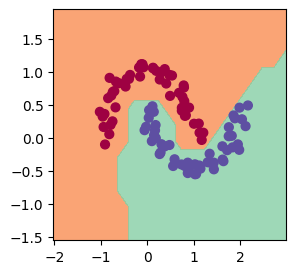

In [7]:
def visualize_decision_boundary(model: MLP, X: ndarray, y: ndarray) -> None:
    # Visualize the decision boundary
    arange_step = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, arange_step), np.arange(y_min, y_max, arange_step)
    )
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([score.data > 0 for score in scores])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(3, 3))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    _ = plt.ylim(yy.min(), yy.max())


visualize_decision_boundary(model, X, y)
